# Global Food Production (Modeling)

---

<img src="notebook_imgs/world_map.png" width='600px'/>
    
---

In general, the majority of this capstone was in exploring the data and finding insights about food production through graphing and statistical methods. Creating plots for top producing country's, top produced food items, and population changes were the main focus of the work. However, with these findings, we also want to create models that we can use to predict future production or categorize countries based on their production.

### Goal
From our findings in the previous notebook, we noticed that yearly global population and yearly global production have a linear relationship. Using the estimated global population as the independent variable (y) and the global production as the dependent variable (x), we will estimate the total production that is expected given a total population value. This will allow us to see what the necessary production would be to support a given population.

However, we will also create a KMeans clustering model to group our data based on food production, partitioning the 174 original country's into $k$ clusters. We will want to use the elbow method in selecting our number of clusters, with an initial guess of using 2 to 3 cluster to separate countries based on high and low production.

---

### Outline

1) [Exploring Future Populations](#section1)
- Obtain population estimates for years 2014-2050 that will be used in modeling.
- Graph the population trend from 1961-2013, as well as the estimated population from 2014-2050.

2) [Simple Linear Model](#section2)
- Create a simple linear model (base model) that puts a best fitting line through data.
- Insights on any observations or discoveries from the graph.

3) [Polynomial Model](#section3)
- **3.1**: Explore values for the degree of the polynomial that minimizes RMSE (is it the best fitting model?).
- **3.2**: Create multiple polynomial model for a few degrees for comparison and graph.

4) [Country Clustering](#section4)
- **4.1**: Format data to be used in clustering (standardize).
- **4.2**: Use elbow method and silhouette score to determine number of clusters.
- **4.3**: Create a model to cluster data together and use graph to visualize.
---

### Imports and Formatting

In [2]:
# import general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import model libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from scipy.stats import zscore
from sklearn.metrics import silhouette_score

# set style parameters for graphs
sns.set_style("darkgrid", {'axes.edgecolor': 'black'})
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams["legend.fontsize"] = 13

In [3]:
prod = pd.read_csv('FAO_FOOD_STAT.csv')
pop = pd.read_csv('FAO_POP_REFORMAT.csv')

<a id='section1'></a>

## 1. Exploring Future Populations

Given that our data ends in 2013, we will use 2014-2050 as the "future" populations (even though the current year is 2021). The recorded populations for 2014-2020 were obtained from [worldometer](https://www.worldometers.info/world-population/world-population-by-year/), as well as the 2021-2050 predictions coming from another [woldometer](https://www.worldometers.info/world-population/world-population-projections/) section. They have been manually copied and placed into a list which I formatted in the same way as the `FAO_POP` data (measured in 1000 persons).

In [4]:
pop_est = [7210845.848 , 7295290.765, 7379797.139, 7464022.049, 7547858.925, 7631091.040, 7713468.100, 7794798.739, 
           7874965.825, 7953952.567, 8031800.429, 8108605.388, 8184437.460, 8259276.737, 8333078.316, 8405863.295, 
           8477660.693, 8548487.400, 8618349.489, 8687227.850, 8755083.431, 8821862.661, 8887524.213, 8952048.940, 
           9015437.653, 9077693.676, 9138828.468, 9198847.240, 9257745.535, 9315508.050, 9372118.186, 9427555.367, 
           9481803.274, 9534854.828, 9586707.986, 9637357.637, 9686800.357, 9735033.990]

dates = np.arange(1961, 2051) # 1961-2050

In [5]:
x = pop.iloc[:, 2:].sum(axis=0).values

y = prod.iloc[:, 10:].sum(axis=0).values

x_train = x.reshape(-1,1) # format for training

pop_ = np.asarray(pop_est).reshape(-1,1) # format for training

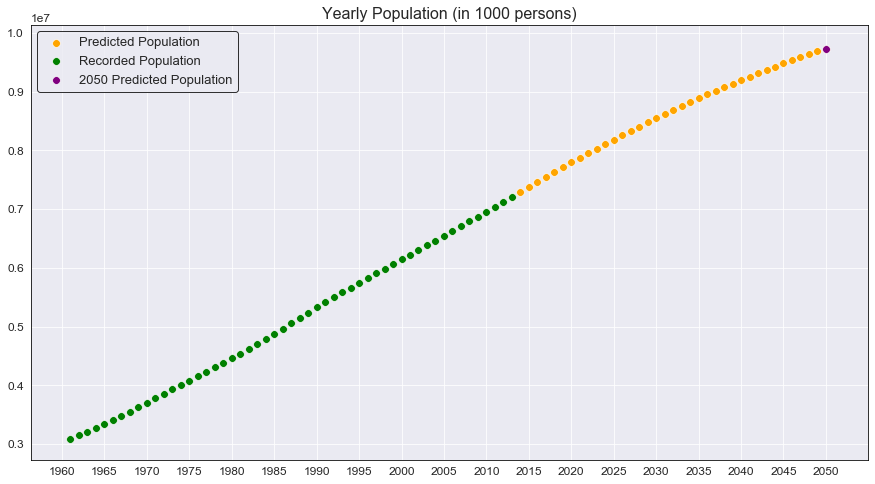

In [6]:
plt.figure(figsize=(15,8))
sns.scatterplot(x=dates[52:], y=pop_est, color='orange', s=60, label = 'Predicted Population')
sns.scatterplot(x=dates[:53], y=x, color='green', s=60, label = 'Recorded Population')
sns.scatterplot(x=dates[-1:], y=pop_est[-1:], color='purple', s=60, label = '2050 Predicted Population')
plt.title('Yearly Population (in 1000 persons)')
plt.xticks(ticks=np.arange(1960, 2051, 5))
plt.show();

**Insights:** We saw in the `DataExploration` notebook that the 1961-2013 population was mostly linear, and it seems that the 2014-2050 seems to follow around the same pattern. For the most part the population seems to be growing linearly, with a slight curve downwards occuring as we approach 2050. Does this mean the population will peak in 2050 and begin to pleateau? Or will it continue to grow and pass 10 billion? These idea's will have to be explored at a later time with more data and context.

<a id='section2'></a>

## 2: Simple Linear Model

Now we will create a simple linear model using [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression), which will be our base model. Given the findings in the `DataExploration` notebook, we know that we most likely need to use a Polynomial Regression model, but a simple linear model will give us a good understanding of our base RMSE value. It is important to note that the data will not be normalized since we only have one features, and are trying to predict its corresponding value. 

In [50]:
def linear_model():
    '''
    Create a simple linear regression model and plot the predictions for 1961-2013, 
    as well as the future predictions from 2014-2050.
    '''
    model = LinearRegression().fit(x_train,y)
    
    linear_train_preds = model.predict(x_train)

    est_2013_2050 = model.predict(pop_)
    
    rmse = round(np.sqrt(mean_squared_error(y, linear_train_preds)), 2)
    print(f'RMSE: {rmse}')
    print(f'2050 Production Estimate: {round(est_2013_2050[-1],3)} (in 1000 tonnes)')
    
    plt.figure(figsize=(16,8))
    sns.scatterplot(x=x, y=y, color='blue', s=80, label='True Values')
    sns.lineplot(x=x, y=linear_train_preds, color='red', alpha=0.7, linewidth=2, label='Linear Model Estimates')
    sns.lineplot(x=pop_est, y=est_2013_2050, color='green', alpha=0.7, linewidth=2, label='Predicted Populations')
    sns.scatterplot(x=pop_est[-1:], y=est_2013_2050[-1:], s=80, color='purple', label='2050 Estimate')
    plt.title('Population vs Production (Yearly Totals)')
    plt.xlabel('Population (in 1000 persons)')
    plt.ylabel('Production (in 1000 tonnes)')
    plt.show();
    
    return None

RMSE: 405017.06
2050 Production Estimate: 17013250.634 (in 1000 tonnes)


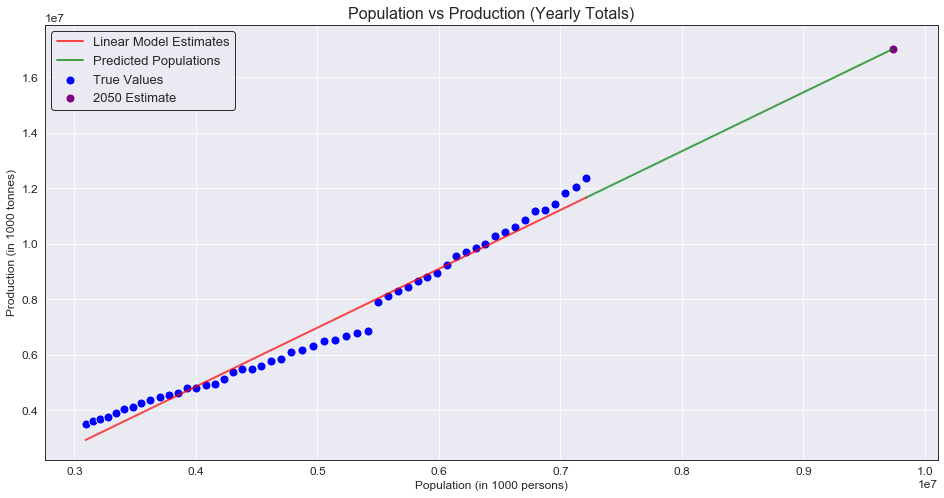

In [51]:
linear_model()

**Insights**: Similar to what we saw in the `DataExploration` notebook, the simple linear model does not fit our data very well, with an RMSE of around 405,000. However, its important to note that the data uses numbers in the millions, so the error was expected to be large. With an estimated production amount of 17013250 (in 1000 tonnes), this does not seem very accurate, since most experts say that we need to double our production to support to 2050 population. This was a good base model to indicate a base RMSE, but we will try to improve this model in the next section.

<a id='section3'></a>

## 3: Polynomial Model

From our base model, we see that the line is not fitting the data very well. A solution to this problem would be to fit a polynomial regression model that allows the line to bend and is better suited for the data. To do this, we will want to find out which degree minimizes the RMSE for the polynomial model, then use a subset of those to graph the predictions and see which model best represents our data. 

### 3.1 Determine the Degree

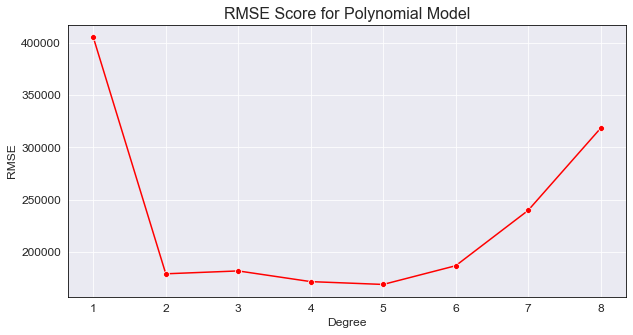

In [232]:
rmse_scores = []
degree_range = np.arange(1,9)

for deg in degree_range:
    poly_features = PolynomialFeatures(degree=deg)
    X_poly = poly_features.fit_transform(x_train)
    
    poly_model = LinearRegression().fit(X_poly, y)
    train_preds = poly_model.predict(X_poly)
    rmse = round(np.sqrt(mean_squared_error(y, train_preds)), 2)
    rmse_scores.append(rmse)

plt.figure(figsize=(10,5))
sns.lineplot(x=degree_range, y=rmse_scores, marker='o', color='red')
plt.title('RMSE Score for Polynomial Model')
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.show();

**Insights**: We can see a degree of 1 represents our base model, but degrees 2-5 seems to minimize the RMSE the best. From the `DataExploration` notebook, we saw a degree 2 model fit quite well, but it also seems that degree 4 and 5 have a lower RMSE. We will want to train a poynomial model using degree 2-5, compare their RMSE as well as their prediction patterns for the future, to determine which model best suits our data. This may mean having a higher RMSE, but we are more focused on the predicted production rather than a minimal error in this case.

### 3.2 Create Multiple Models

In [66]:
def poly_model(deg_range):
    '''
    Create a polynomial regression model with a given degree range. Use 
    the model to predict years 2014-2050, as well as plot as data.
    Note that graph is set up for only 4 different degree values.
    '''
    rmse_scores = []
    preds_2050 = []
    future_preds = []
    poly_train_preds = []
    
    for degree in deg_range:
        poly_feat = PolynomialFeatures(degree=degree)
        X_poly = poly_feat.fit_transform(x_train)

        poly_model = LinearRegression().fit(X_poly, y)

        poly_2014_2050 = poly_feat.fit_transform(pop_)

        yhat = poly_model.predict(X_poly)
        future_yhat = poly_model.predict(poly_2014_2050)
        
        rmse_scores.append(round(np.sqrt(mean_squared_error(y, yhat)), 2))
        preds_2050.append(round(future_yhat[-1],3))
        future_preds.append(future_yhat)
        poly_train_preds.append(yhat)
    
    model_info = pd.DataFrame(data = deg_range, columns=['Degree'])
    model_info['RMSE'] = rmse_scores
    model_info['2050 Production Estimation'] = preds_2050
    
    display(model_info.round(2))
    
    fig, axes = plt.subplots(2,2, figsize=(16,10))
    i=0
    for row in range(0,2):
        for col in range(0,2):
            sns.lineplot(ax=axes[row, col], x=x, y=poly_train_preds[i], color='red', alpha=0.7, 
                         linewidth=2, label='Poly Model Estimates')
            sns.scatterplot(ax=axes[row, col], x=x, y=y, color='blue', s=80, label='True Values')
            sns.lineplot(ax=axes[row, col], x=pop_est, y=future_preds[i], alpha=0.7, linewidth=2, 
                         color='green', label='Predicted Populations')
            sns.scatterplot(ax=axes[row, col], x=pop_est[-1:], y=future_preds[i][-1:], s=100, 
                            color='purple', label='2050 Estimate')
            axes[row, col].set_title(f'Population vs Production (Degree {deg_range[i]})')
            plt.xlabel('Population (in 1000 persons)')
            plt.ylabel('Production (in 1000 tonnes)')
            i += 1
    
    model_info = None
    return None

,Degree,RMSE,2050 Production Estimation
0,2,179427.41,22463820.97
1,3,182169.96,23084034.55
2,4,171969.60,17341906.93
3,5,169272.95,13500278.99


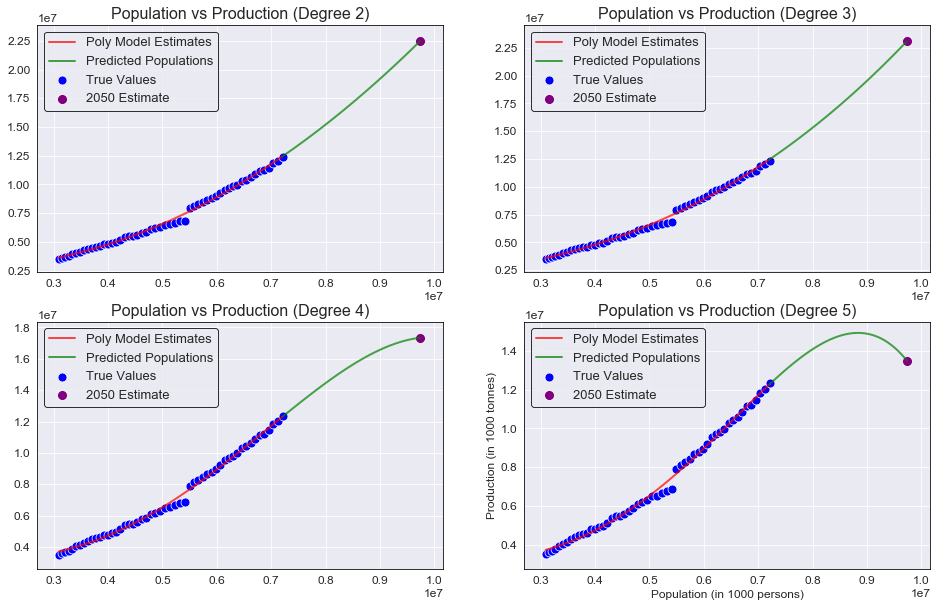

In [67]:
deg_range = np.arange(2,6)
poly_model(deg_range)

**Insights**: *To be filled in...*

<a id='section4'></a>

## 4. Country Clustering

### 4.1: Format Data

In [169]:
# Format data to be clustered (grouped by country)
data = prod.copy()
data.drop(['Area Abbreviation', 'Area Code', 'Item Code', 'Item', 'Element Code', 'Element', 'Unit',
           'latitude', 'longitude'], axis=1, inplace=True)

data = data.groupby('Area').agg('sum')
data_scaled = data.apply(zscore)

X = data_scaled.values
countries = data_scaled.index.values

data_scaled.head()

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,-0.163861,-0.169612,-0.179311,-0.169651,-0.166441,-0.175412,-0.164236,-0.167893,-0.167506,-0.187094,...,-0.201430,-0.196125,-0.196535,-0.192368,-0.191741,-0.183046,-0.180323,-0.181643,-0.174548,-0.175621
Albania,-0.283499,-0.284815,-0.290403,-0.292117,-0.286017,-0.284625,-0.286017,-0.287853,-0.287550,-0.285347,...,-0.248315,-0.246936,-0.249098,-0.248034,-0.243963,-0.238848,-0.233207,-0.231963,-0.228937,-0.229497
Algeria,-0.194528,-0.202362,-0.214208,-0.212761,-0.207706,-0.210592,-0.207755,-0.202177,-0.202724,-0.200493,...,-0.049595,-0.047933,-0.045611,-0.055762,-0.056899,-0.028983,-0.022992,-0.008230,0.000651,0.004092
Angola,-0.235367,-0.239335,-0.238455,-0.241880,-0.235299,-0.235430,-0.236122,-0.242690,-0.237591,-0.235788,...,-0.158834,-0.154144,-0.150774,-0.145049,-0.137556,-0.114787,-0.110323,-0.106185,-0.116881,-0.081907
Antigua and Barbuda,-0.308334,-0.309689,-0.315263,-0.318648,-0.311076,-0.310305,-0.312131,-0.314956,-0.314628,-0.313608,...,-0.279296,-0.277612,-0.280440,-0.277515,-0.274122,-0.268963,-0.264608,-0.262947,-0.259382,-0.259302


**Insights**: We could have left the data how it was and use it for the clustering algorithm, but this resulted in extremely large inertia values (used below). To counter this, I used a zscore to standardize the data, which now is in the range [-0.322, 11.41], and our intertia is much more easily interpreted.

### 4.2 Selecting Number of Clusters

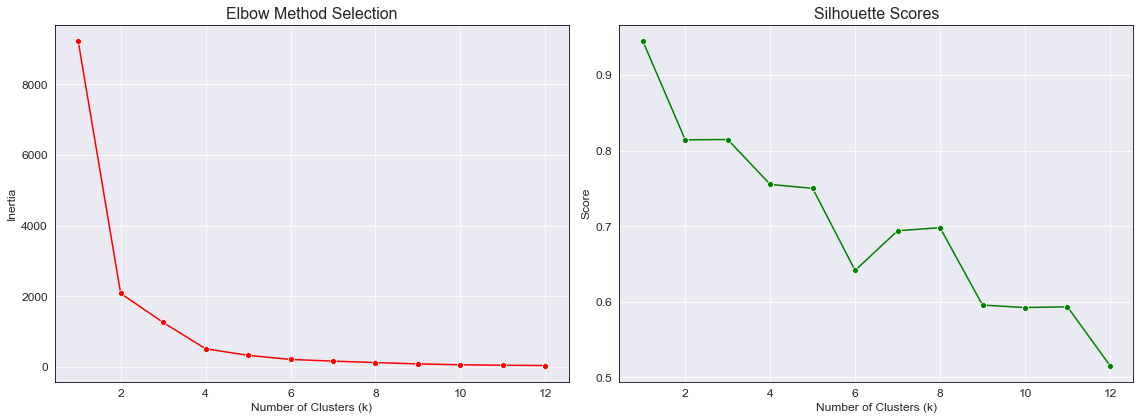

In [170]:
# Elbow Method & Silhouette Score

num_clusters = np.arange(1,13) # 2-6 clusters
inertia = []
score = []

for clusters in num_clusters:
    model = KMeans(n_clusters=clusters, random_state=42).fit(X)
    inertia.append(model.inertia_)

for clusters in (num_clusters+1):
    model = KMeans(n_clusters=clusters, random_state=42).fit(X)
    score.append(silhouette_score(X, model.labels_, metric='euclidean'))

plt.figure(figsize=(16,6))
ax1 = plt.subplot(1,2,1)
sns.lineplot(x=num_clusters, y=inertia, marker='o', color='red')
plt.title('Elbow Method Selection')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

ax2 = plt.subplot(1,2,2)
sns.lineplot(x=num_clusters, y=score, marker='o', color='green')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')

plt.tight_layout()
plt.show();

**Insights**: Using the elbow method for the intertia graph, it seems that 2 is the ideal cluster number (but 3 and 4 could also be considered). We also used a [silhouette score](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) to determine help determine the number of clusters, which helps determine the distance between the resulting clusters, and we want a value of as close to 1 as possible. Using both of there, it seems that 2 clusters is ideal since this is where the elbow occurs and also has the highest silhouette score (besides 1 which is not considered in this case).

### 4.3: Model

In [182]:
model = KMeans(n_clusters=2, random_state=42).fit(X)
y_preds = model.predict(X)

# Add labels to data
data['labels'] = y_preds

# Get labels for graph (only labels 1)
labels = list(data[data.labels == 1].index.values)
labels = '\n'.join(labels)

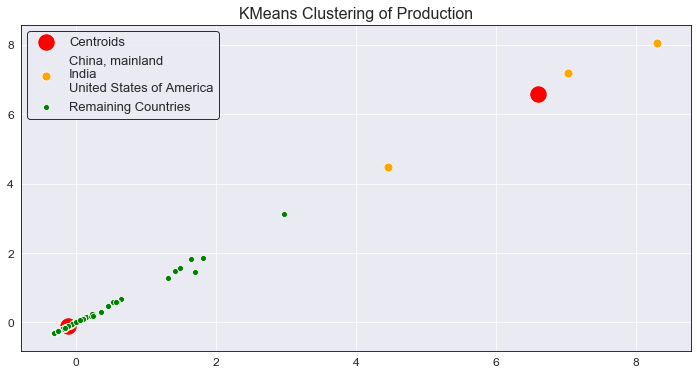

In [187]:
plt.figure(figsize=(12,6))
sns.scatterplot(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=300, color='red', label='Centroids')
sns.scatterplot(x=X[y_preds == 1, 0], y=X[y_preds == 1,1], s=80, color='orange', label=labels)
sns.scatterplot(x=X[y_preds == 0, 0], y=X[y_preds == 0,1], color='green', label='Remaining Countries')
plt.title('KMeans Clustering of Production')
plt.legend(loc='upper left')
plt.show();

**Insights**: As expected, using 2 clusters seperated the top 3 producers from the remaining countries. This means the clusters are based on high vs low production, since from the `DataExploration` notebook we saw that the top 3 countries were responsible for over 40% of the global production. The next closest country (Brazil) produced less than 1/3 the amount that the United States or India does and around 1/6 the amount of China. These clusters seem to be accurate in seperating our data in correct clusters, and helps us visual how much more the top 3 countries produced compared to the remaining countries.